In [4]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd


In [0]:
pd.set_option("display.precision", 8)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_root='/content/drive/My Drive/train'

In [23]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="validation",shuffle=True,target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="training",shuffle=True,target_size=IMAGE_SHAPE)

/content/drive/My Drive/train
Found 520 images belonging to 48 classes.
Found 2168 images belonging to 48 classes.


In [24]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 48)
['Apple' 'Asparagus' 'Aubergine' 'Avocado' 'Banana' 'Brown-Cap-Mushroom'
 'Cabbage' 'Carrots' 'Cucumber' 'Garlic' 'Ginger' 'Juice' 'Kiwi' 'Leek'
 'Lemon' 'Lime' 'Mango' 'Melon' 'Milk' 'Nectarine' 'Oat-Milk' 'Oatghurt'
 'Onion' 'Orange' 'Papaya' 'Passion-Fruit' 'Peach' 'Pear' 'Pepper'
 'Pineapple' 'Plum' 'Pomegranate' 'Potato' 'Red-Beet' 'Red-Grapefruit'
 'Satsumas' 'Sour-Cream' 'Sour-Milk' 'Soy-Milk' 'Soyghurt' 'Tomato'
 'Yoghurt' 'Zucchini' 'Chicken' 'Corn' 'Milk' 'Snowpeas' 'White-Mushroom']


In [25]:
model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",output_shape=[1280],trainable=False),tf.keras.layers.Dropout(0.4),tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])
model.build([None, 224, 224, 3])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  61488     
Total params: 2,319,472
Trainable params: 61,488
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(train_generator,epochs=10,verbose=1,steps_per_epoch=steps_per_epoch,validation_data=valid_generator,validation_steps=val_steps_per_epoch).history

Epoch 1/10
68/68 [==============================] - 78s 1s/step - loss: 2.3772 - acc: 0.2592 - val_loss: 1.1954 - val_acc: 0.6558
Epoch 2/10
68/68 [==============================] - 18s 270ms/step - loss: 0.7733 - acc: 0.7437 - val_loss: 0.7178 - val_acc: 0.7962
Epoch 3/10
68/68 [==============================] - 17s 254ms/step - loss: 0.4551 - acc: 0.8803 - val_loss: 0.5561 - val_acc: 0.8596
Epoch 4/10
68/68 [==============================] - 18s 272ms/step - loss: 0.2999 - acc: 0.9299 - val_loss: 0.4513 - val_acc: 0.8885
Epoch 5/10
68/68 [==============================] - 18s 272ms/step - loss: 0.2228 - acc: 0.9549 - val_loss: 0.4078 - val_acc: 0.8942
Epoch 6/10
68/68 [==============================] - 18s 261ms/step - loss: 0.1731 - acc: 0.9715 - val_loss: 0.3510 - val_acc: 0.9115
Epoch 7/10
68/68 [==============================] - 18s 269ms/step - loss: 0.1491 - acc: 0.9745 - val_loss: 0.3292 - val_acc: 0.9135
Epoch 8/10
68/68 [==============================] - 17s 253ms/step - los

In [0]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [66]:
val_image_batch, val_label_batch = next(iter(valid_generator))

true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [75]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
tf_pred_dataframe.head()

,Apple,Asparagus,Aubergine,Avocado,Banana,Brown-Cap-Mushroom,Cabbage,Carrots,Cucumber,Garlic,Ginger,Juice,Kiwi,Leek,Lemon,Lime,Mango,Melon,Milk,Nectarine,Oat-Milk,Oatghurt,Onion,Orange,Papaya,Passion-Fruit,Peach,Pear,Pepper,Pineapple,Plum,Pomegranate,Potato,Red-Beet,Red-Grapefruit,Satsumas,Sour-Cream,Sour-Milk,Soy-Milk,Soyghurt,Tomato,Yoghurt,Zucchini,Chicken,Corn,Milk,Snowpeas,White-Mushroom
0,0.00004664,0.00011679,0.00004007,0.00022458,0.00000004,0.00007754,0.00003406,0.00001891,0.00010511,0.00007389,0.00003214,0.14865498,0.00021814,0.00003230,0.00000900,0.00001691,0.00009727,0.00000601,0.52532780,0.00040578,0.00184428,0.00464222,0.00004823,0.00000165,0.00008282,0.00004481,0.00013990,0.00001916,0.00002838,0.00002245,0.00003099,0.00001559,0.00002730,0.00009273,0.00000066,0.00003163,0.08927052,0.02928689,0.02472881,0.00478307,0.00018087,0.16878776,0.00008556,0.00004087,0.00002765,0.00014752,0.00003046,0.00001928
1,0.00000577,0.00253562,0.00003246,0.00002446,0.00000003,0.00006380,0.00000175,0.00000598,0.00000677,0.00009781,0.00000950,0.02170905,0.00006383,0.00003518,0.00000147,0.00000010,0.00000602,0.00000019,0.00238703,0.00000304,0.00130681,0.05664502,0.00000266,0.00000507,0.00002692,0.00002911,0.00000220,0.00000196,0.00001176,0.00002379,0.00000394,0.00000222,0.00000153,0.00001361,0.00000090,0.00000064,0.00018769,0.00126664,0.00446072,0.86802435,0.00012796,0.04079494,0.00003692,0.00001702,0.00000064,0.00001400,0.00000105,0.00000008
2,0.00002208,0.00027119,0.00050228,0.00002786,0.00004699,0.00002158,0.00003472,0.00004074,0.00006702,0.00004707,0.00000288,0.00038053,0.00000935,0.00002783,0.00014781,0.00000745,0.00001910,0.00481642,0.00000184,0.00064699,0.00000130,0.00000032,0.00000282,0.00000060,0.98161894,0.00821145,0.00001966,0.00031770,0.00012581,0.00001897,0.00003043,0.00000350,0.00003700,0.00001505,0.00000010,0.00000163,0.00000180,0.00000009,0.00000879,0.00000129,0.00000044,0.00001296,0.00241086,0.00000132,0.00000078,0.00000201,0.00001231,0.00000034
3,0.08860673,0.00006340,0.00006638,0.00022897,0.00000412,0.00010495,0.00003367,0.00009034,0.00003800,0.00002307,0.00002908,0.00001697,0.00104523,0.00000460,0.00002906,0.00012106,0.00007289,0.00000385,0.00001015,0.00284506,0.00001838,0.00000904,0.00045315,0.00788293,0.00000970,0.00022054,0.00008171,0.00049452,0.00305726,0.00008210,0.00002171,0.00692243,0.00003414,0.00001862,0.04095610,0.00628575,0.00000706,0.00000214,0.00001165,0.00001103,0.83978641,0.00001554,0.00005220,0.00001040,0.00001324,0.00005050,0.00005187,0.00000214
4,0.00018359,0.00066152,0.00020354,0.00003746,0.99406707,0.00003460,0.00001062,0.00009994,0.00050946,0.00007775,0.00002009,0.00001260,0.00000792,0.00014343,0.00012899,0.00005260,0.00000808,0.00001623,0.00000384,0.00000367,0.00000051,0.00000057,0.00001623,0.00001557,0.00009429,0.00000699,0.00000118,0.00097495,0.00031366,0.00061387,0.00000421,0.00000673,0.00002279,0.00000815,0.00000805,0.00000664,0.00000565,0.00000176,0.00004759,0.00002269,0.00000543,0.00018493,0.00122480,0.00001661,0.00002300,0.00000545,0.00006237,0.00002230


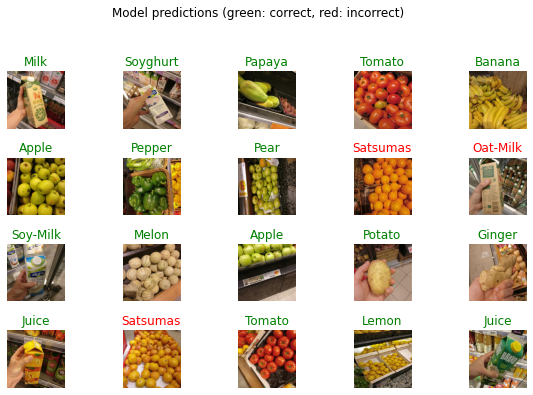

In [79]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")